## Use ML to diffrentiate between PTSD and Combat control group on resting state data (10m)

In [2]:
work_dir = '/media/Data/work/RCF_or/RS'

# %%load parcellation (Yeo? / Shen?)
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nilearn
from nilearn import input_data
from nilearn import plotting
import scipy
import seaborn as sns
from sklearn.covariance import GraphicalLassoCV

In [3]:
# shen
atlas_filename = '/home/or/Downloads/shenPar/shen_1mm_268_parcellation.nii.gz'
atlas_labes = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels.csv')
colors = pd.read_csv('/home/or/Downloads/shenPar/shen_268_parcellation_networklabels_colors.csv')
coords = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)

atlas_labes = np.array(atlas_labes)
atlas_labes.shape

(268, 2)

In [4]:
# add sphere around each 
coords
masker = nilearn.input_data.NiftiSpheresMasker(
    seeds=coords, smoothing_fwhm=6, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=1)


In [5]:
# extract RS data and create vector for each subject
def removeVars (confoundFile):
    # this method takes the csv regressors file (from fmriPrep) and chooses a few to confound. You can change those few
    import pandas as pd
    confound = pd.read_csv(confoundFile,sep="\t", na_values="n/a")
    finalConf = confound[['csf','white_matter', 'framewise_displacement', 'dvars', 'std_dvars',
                          'trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z',
                        ]] # can add 'global_signal' also ,
     # change NaN of FD to zero
    finalConf = np.array(finalConf.fillna(0.0))
    #finalConf[0,2] = 0 # if removing FD than should remove this one also
    return finalConf
#from nilearn.input_data import NiftiMasker
    # define masker here

from nilearn.input_data import NiftiLabelsMasker
# masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True,t_r=1, high_pass=.01, low_pass=0.1,
#                            smoothing_fwhm=6
#                            )

    
# from nilearn.connectome import ConnectivityMeasure

# connectome_measure = ConnectivityMeasure(kind='partial correlation', vectorize = False, discard_diagonal=False)

## if using lasso
covariance_estimator = GraphicalLassoCV(cv=4,  n_jobs=10)

In [65]:
# take func and confound files and extract vectors for each
subject_list = ['020','029','030','038','040', '1005', '1072', '1074', '1099', '1205', '1206', '1210', '1212', '1216',
                '1218',  '1223', '1237',  '1245', '1247', '1254', '1258', '1266', '1268', '1269', '1271', 
                '1272', '1280', '1290', '1291', '1301', '1303', '1309', '1312',  '1319', '1320', '1326', '1337', 
                '1338', '1340', '1343', '1345', '1346', '1347','1350', '1357', '1359', '1362','1373', '1374', 
                '1376',   '1384', '1388', '1389', '1392', '1393', '1423','1431', '1432', '1440', '1444',
                '1445', '1449', '1457', '1460'] #'1220','1378','1221','1379',

func_template = '/media/Data/Lab_Projects/RCF/neuroimaging/RCF_Bids/derivatives/fmriprep/sub-{sub}/ses-{session}/func/sub-{sub}_ses-{session}_task-resting600_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
confound_template = '/media/Data/Lab_Projects/RCF/neuroimaging/RCF_Bids/derivatives/fmriprep/sub-{sub}/ses-{session}/func/sub-{sub}_ses-{session}_task-resting600_desc-confounds_regressors.tsv'

In [7]:
### Run this only to extract timeseries from the start if it was extracted already - run next cell only
session = '1'
for sub in subject_list:
    print(f'Analyzing subject {sub}')
    confound = confound_template.format(sub=sub, session = session)    
    filename = func_template.format(sub=sub, session = session)
   
    try:
        timeseries_each_subject = masker.fit_transform(filename, confounds=removeVars(confound))
        np.save(work_dir + '/sub-'+ sub + '_session1RS',timeseries_each_subject)
    except:
        print (f'Subject {sub} have no data file')
    

Analyzing subject 020
Analyzing subject 029
Analyzing subject 030
Analyzing subject 038
Analyzing subject 040
Analyzing subject 1005
Analyzing subject 1072
Analyzing subject 1074
Analyzing subject 1099
Analyzing subject 1205
Analyzing subject 1206
Analyzing subject 1210
Analyzing subject 1212
Analyzing subject 1216
Analyzing subject 1218
Analyzing subject 1220
Subject 1220 have no data file
Analyzing subject 1221
Analyzing subject 1223
Analyzing subject 1237
Analyzing subject 1245
Analyzing subject 1247
Analyzing subject 1254
Analyzing subject 1258
Analyzing subject 1266
Analyzing subject 1268
Analyzing subject 1269
Analyzing subject 1271
Analyzing subject 1272
Analyzing subject 1280
Analyzing subject 1290
Analyzing subject 1291
Analyzing subject 1301
Analyzing subject 1303
Analyzing subject 1309
Analyzing subject 1312
Analyzing subject 1319
Analyzing subject 1320
Analyzing subject 1326
Analyzing subject 1337
Analyzing subject 1338
Analyzing subject 1340
Analyzing subject 1343
Analyzin

In [66]:
## load files and run lasso
correlations = []
for sub in subject_list:
    print(f'Running subject {sub}')
    ts = np.load(work_dir + '/sub-'+ sub + '_session1RS.npy')
    covariance_estimator.fit(ts)
    # transfer to fishers' z
    mat = np.arctan(covariance_estimator.covariance_)
    correlations.append(mat)
correlations = np.squeeze(correlations)
correlations.shape

Running subject 020
Running subject 029


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.226e-03
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 030
Running subject 038
Running subject 040
Running subject 1005
Running subject 1072
Running subject 1074
Running subject 1099
Running subject 1205
Running subject 1206
Running subject 1210
Running subject 1212
Running subject 1216
Running subject 1218
Running subject 1223
Running subject 1237
Running subject 1245


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 2.458e-04
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1247
Running subject 1254
Running subject 1258
Running subject 1266
Running subject 1268


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 1.291e-04
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1269


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.312e-03
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1271
Running subject 1272
Running subject 1280
Running subject 1290
Running subject 1291
Running subject 1301
Running subject 1303
Running subject 1309
Running subject 1312
Running subject 1319
Running subject 1320
Running subject 1326
Running subject 1337
Running subject 1338
Running subject 1340
Running subject 1343
Running subject 1345
Running subject 1346
Running subject 1347
Running subject 1350
Running subject 1357
Running subject 1359
Running subject 1362


/home/or/miniconda3/envs/neuroAnalysis/lib/python3.7/site-packages/sklearn/covariance/_graph_lasso.py:263: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -2.346e-04
  % (max_iter, d_gap), ConvergenceWarning)


Running subject 1373
Running subject 1374
Running subject 1376
Running subject 1384
Running subject 1388
Running subject 1389
Running subject 1392
Running subject 1393
Running subject 1423
Running subject 1431
Running subject 1432
Running subject 1440
Running subject 1444
Running subject 1445
Running subject 1449
Running subject 1457
Running subject 1460


(64, 268, 268)

## Grab group data from scansheet

In [67]:
groups = pd.read_excel('/media/Data/Lab_Projects/RCF/Subjects and stimuli list.xlsx')
groups = groups[['Sub', 'group']]
sub_groups = list(groups['Sub'].values)
sub_groups
sub_groups = list(map(str, sub_groups))


In [68]:
## need to compare the lists 
# create a list of subjects that are in both lists
join_sub = list(set(subject_list) & set(sub_groups))
# create dataframe that only has those subjects
dfGroup = groups.loc[groups['Sub'].isin(join_sub)]

In [69]:
dfGroup

,Sub,group
5,1005,FPTSD
6,1072,CC
7,1074,PTSD
8,1099,CC
9,1205,PTSD
10,1206,CC
11,1210,CC
12,1212,CC
13,1216,CC
14,1218,CC


## Plot mean correlation matrix

In [1]:
# Tweak edge_threshold to keep only the strongest connections.
mean_corrMat = np.mean(correlations, axis=0)
plotting.plot_connectome(mean_corrMat, coords, title='Power correlation graph',
                         edge_threshold='99.8%', node_size=20, colorbar=True)

NameError: name 'np' is not defined

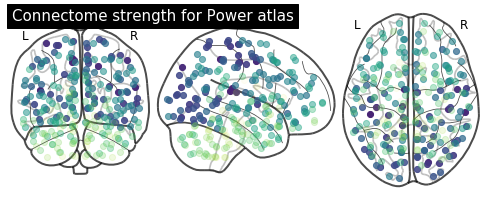

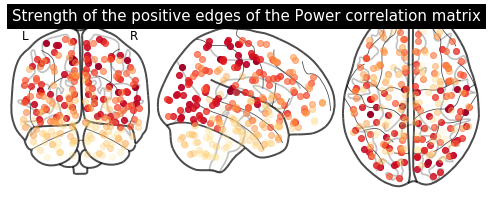

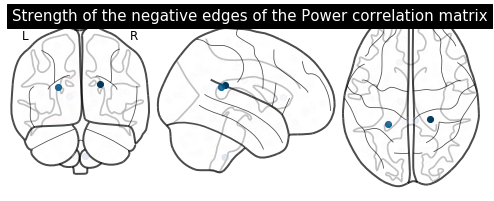

In [62]:
## plot strength
plotting.plot_connectome_strength(
    mean_corrMat, coords, title='Connectome strength for Power atlas'
)

## just positive
from matplotlib.pyplot import cm

# plot the positive part of of the matrix
plotting.plot_connectome_strength(
    np.clip(mean_corrMat, 0, mean_corrMat.max()), coords, cmap=cm.YlOrRd,
    title='Strength of the positive edges of the Power correlation matrix'
)

# plot the negative part of of the matrix
plotting.plot_connectome_strength(
    np.clip(mean_corrMat, mean_corrMat.min(), 0), coords, cmap=cm.PuBu,
    title='Strength of the negative edges of the Power correlation matrix'
)


In [ ]:
## make everything ready for ML
# turn to vector
vec_corr = []
for i in correlations:
    corVec = nilearn.connectome.sym_matrix_to_vec(i)
    vec_corr.append(corVec)
np.array(vec_corr).shape

## Setting variables

In [ ]:
X = np.array(vec_corr)
#X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X.shape

In [ ]:
#label each group
# 1 = ketamine, 0 = midazolam
group_label = ['1', '1', '2', '2', '1', '1', '1', '1', '1', '1', '2', '2', '2', '2', '1', '2', '2', '1', '2', '2']#, '1']
Y = group_label

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

model = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=5, shuffle=True) # running for each subject
mean_scores = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(model,
                            X,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores.append(cv_scores.mean())

In [ ]:
cv_scores

In [ ]:
n_iter = 100
rand_score = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model,
                            X,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score.append(mean_scores)

In [ ]:
rand_score = np.array(rand_score)
print(f'Accuracy: {np.mean(rand_score)} (CI5%-95% {np.quantile(rand_score, [0.05,0.95])})')
sns.distplot(rand_score)

In [ ]:
## Lets do permutation tests - shuffling the condition label
import random
condPerm = np.array(group_label)
permScor = []
#cv = KFold(n_splits=10)
for i in range(n_iter):
    print (f'Running the {i+1} iteration')
    random.shuffle(condPerm)
    print(condPerm)
    
    mean_scores = []
    cv_scores = cross_val_score(model,
                            X,
                            y=condPerm,
                            cv=cv,
                            groups=condPerm,
                            scoring="roc_auc",
                            n_jobs=11, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(cv_scores.mean())
    permScor.append(mean_scores)

In [ ]:
permScor = np.array(permScor)
print(f'AUC: {np.mean(permScor)} (CI5%-95% {np.quantile(permScor, [0.05,0.95])})')
sns.distplot(permScor)

## To test ourselfs - lets compare the first session
We expect no differences at all in this one

In [ ]:
session = '1'
correlations_1 = []
for sub in subject_list:
    print(f'Analyzing subject {sub}')
    confound = confound_template.format(sub=sub, session = session)    
    filename = func_template.format(sub=sub, session = session)
   
    try:
        timeseries_each_subject = masker.fit_transform(filename, confounds=removeVars(confound))
    except:
        print (f'Subject {sub} have no data file')
    
    #correlation = connectome_measure.fit_transform([timeseries_each_subject])
    #correlation = np.arctan(correlation) # z transform it
    #correlations.append(correlation)
    covariance_estimator.fit(timeseries_each_subject)
    correlations_1.append(covariance_estimator.covariance_)

# Get array in good numpy structure
correlations_1 = np.squeeze(correlations_1)

In [ ]:
## make everything ready for ML
# turn to vector
vec_corr1 = []
for i in correlations_1:
    corVec = nilearn.connectome.sym_matrix_to_vec(i)
    vec_corr1.append(corVec)
np.array(vec_corr1).shape

In [ ]:
X_1 = np.array(vec_corr1)
#X = X.reshape(X.shape[0], midArr_reshape.shape[1])
X_1.shape

In [ ]:
model2 = XGBClassifier(n_jobs=8, 
                     verbose = 9, random_state=None)

## Here we use stratified K-fold with shuffling to generate different shuffling of leave one subject out
cv = StratifiedKFold(n_splits=6, shuffle=True) # running for each subject
mean_scores2 = []

#svc = svm.SVC(kernel="rbf") #LinearSVC(random_state=None, verbose=5, C=1)
cv_scores = cross_val_score(model2,
                            X_1,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            verbose = 5 # set some details of the activity 
                            )
mean_scores2.append(cv_scores.mean())

In [ ]:
cv_scores

In [ ]:
n_iter = 100
rand_score1 = []
for i in range(n_iter):
    print(f' Running {i+1} iteration')
    mean_scores = []
    scores = cross_val_score(model2,
                            X_1,
                            y=group_label,
                            cv=cv,
                            groups=group_label,
                            scoring= "roc_auc",
                            n_jobs=10, # set number of CPUs
                            #verbose = 5 # set some details of the activity 
                            )
    mean_scores.append(scores.mean())
    rand_score1.append(mean_scores)

In [ ]:
rand_score1 = np.array(rand_score1)
print(f'AUC: {np.mean(rand_score1)} (CI5%-95% {np.quantile(rand_score1, [0.05,0.95])})')
sns.distplot(rand_score1)

### First session results are basically noise, as expected

In [ ]:
## lets build ROC 
## taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

y=np.array(list(map(int, group_label)) )
cv = StratifiedKFold(n_splits=3, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    
    model.fit(X[train], y[train])
    viz = plot_roc_curve(model, X[test,:], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic KPE")
ax.legend(loc="lower right")
plt.show()

